In [1]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error

%matplotlib inline
os.chdir('/data/arpit.goel/32_RecruitRestarauntPrediction/')

df_air_visit_data=pd.read_csv('01.RawData/air_visit_data.csv',parse_dates=['visit_date'])
df_date_info=pd.read_csv('01.RawData/date_info.csv',parse_dates=['calendar_date'])
df_sample_submission=pd.read_csv('01.RawData/sample_submission.csv')


In [2]:
df_air_visit_data.loc[:,'log_visitors']=np.log(1+df_air_visit_data.loc[:,'visitors'])
daily_visits=df_air_visit_data.groupby(['air_store_id','visit_date'])['log_visitors'].max().unstack()
daily_visits.head()

visit_date,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00,...,2017-04-13 00:00:00,2017-04-14 00:00:00,2017-04-15 00:00:00,2017-04-16 00:00:00,2017-04-17 00:00:00,2017-04-18 00:00:00,2017-04-19 00:00:00,2017-04-20 00:00:00,2017-04-21 00:00:00,2017-04-22 00:00:00
air_store_id,,,,,,,,,,,,,,,,,,,,,
air_00a91d42b08b08d9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.555348,3.688879,NaN,NaN,2.995732,3.583519,2.890372,3.663562,4.025352,2.944439
air_0164b9927d20bcc3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.639057,2.079442,0.693147,NaN,1.098612,0.693147,2.197225,0.693147,3.295837,1.945910
air_0241aa3964b7f861,NaN,NaN,2.397895,2.302585,2.890372,2.397895,NaN,1.791759,2.197225,2.833213,...,NaN,1.609438,2.772589,2.397895,2.564949,2.995732,2.197225,NaN,1.386294,2.639057
air_0328696196e46f18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.302585,1.609438,1.386294,1.386294,NaN,3.218876,NaN,2.995732,2.197225
air_034a3d5b40d5b1b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.135494,2.944439,3.465736,3.688879,3.258097,3.044522,3.465736,2.564949,3.637586,3.583519


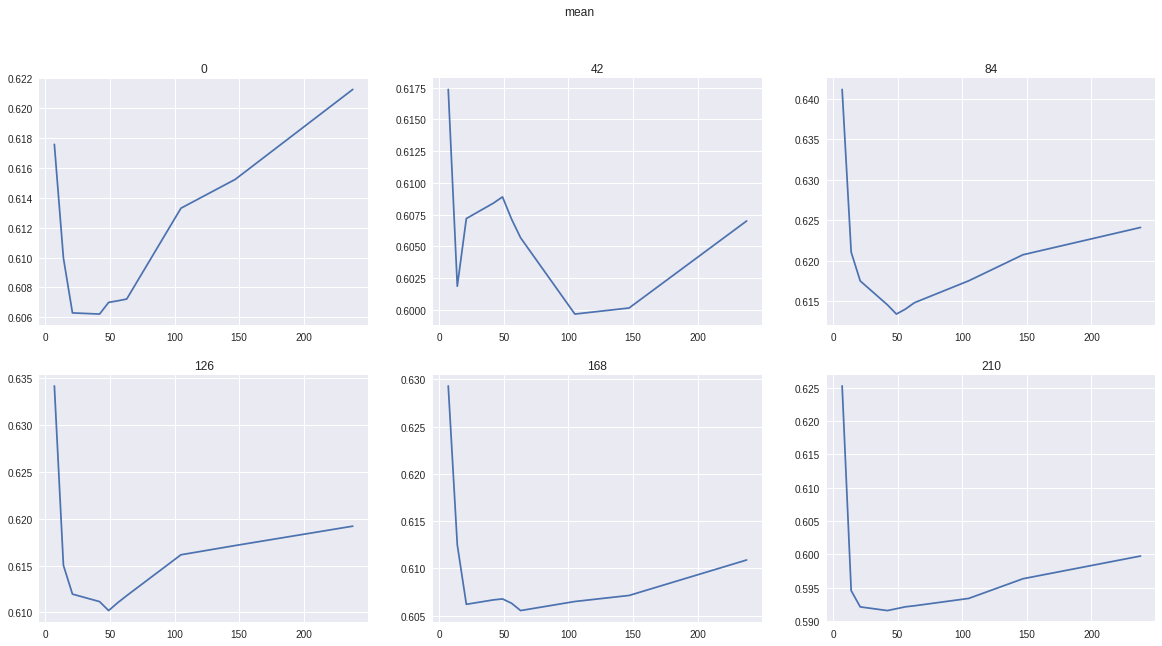

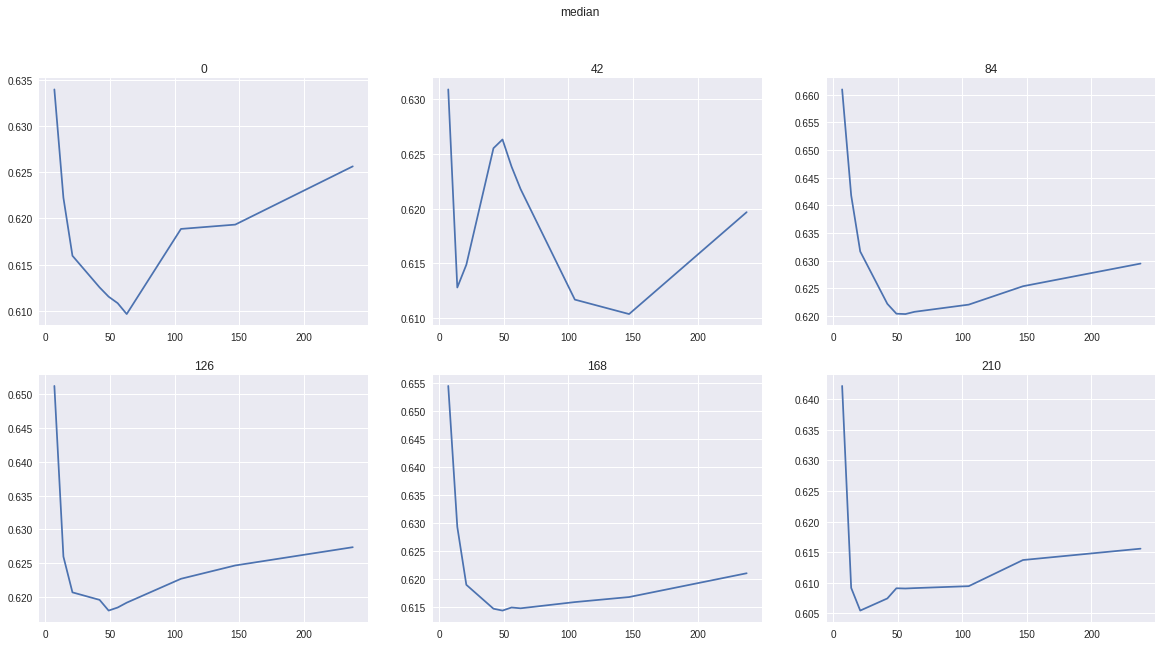

In [59]:
from itertools import product
TEST_PERIOD=42 #Period is 39 days but take 42 days to make sure that that weekly patterns are captured

def get_prediction_error(x,window,timedelta,roll):
    test=x[-TEST_PERIOD-timedelta:len(x)-timedelta].dropna()
    train=x[-TEST_PERIOD-1-window-timedelta:-TEST_PERIOD-1-timedelta].dropna()
    if len(train)==0:
        return pd.Series({'sq_error':0,'len':0})
    if func=='mean':
        prediction=train.mean()
    else:
        prediction=train.median()
    sq_error=np.square(test-prediction).sum()
    return pd.Series({'sq_error':sq_error,'len':len(test)})
    

time_delta=[0,42,84,126,168,210]
windows=[7,14,21,42,49,56,63,105,147,238] 
space=[x for x in product(windows,time_delta)]

for func in ['mean','median']:
    errors=[daily_visits.apply(get_prediction_error,axis=1,window=x,timedelta=y,roll=func).sum() for x,y in space]
    errors=pd.DataFrame(errors,index=pd.MultiIndex.from_tuples(space))
    errors['rmsle']=np.sqrt(errors['sq_error']/errors['len'])
    plt.figure(figsize=(20,10))
    plt.suptitle(func)
    for i,(name,group) in enumerate(errors.groupby(errors.index.get_level_values(1))):
        plt.subplot(2,3,i+1)
        plt.plot(group.index.get_level_values(0),group['rmsle'])
        plt.title(name)


In [4]:
TEST_PERIOD=42 #Period is 39 days but take 42 days to make sure that that weekly patterns are captured
TRAINING_WINDOW_OVERALL=70 #Take 70 days as training window and get median visits as benchmark

predictions=daily_visits.apply(lambda x: x[-TRAINING_WINDOW_OVERALL:].dropna().median(),axis=1)
predictions=np.exp(predictions)-1
predictions=np.round(predictions)
df_sample_submission['visitors']=df_sample_submission['id'].map(lambda x: x[:-11]).map(predictions)
df_sample_submission.to_csv('03.Submissions/1.MedianSubmissionGlobal.csv',index=False)

/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: Mean of empty slice
/home/arpit.goel2/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


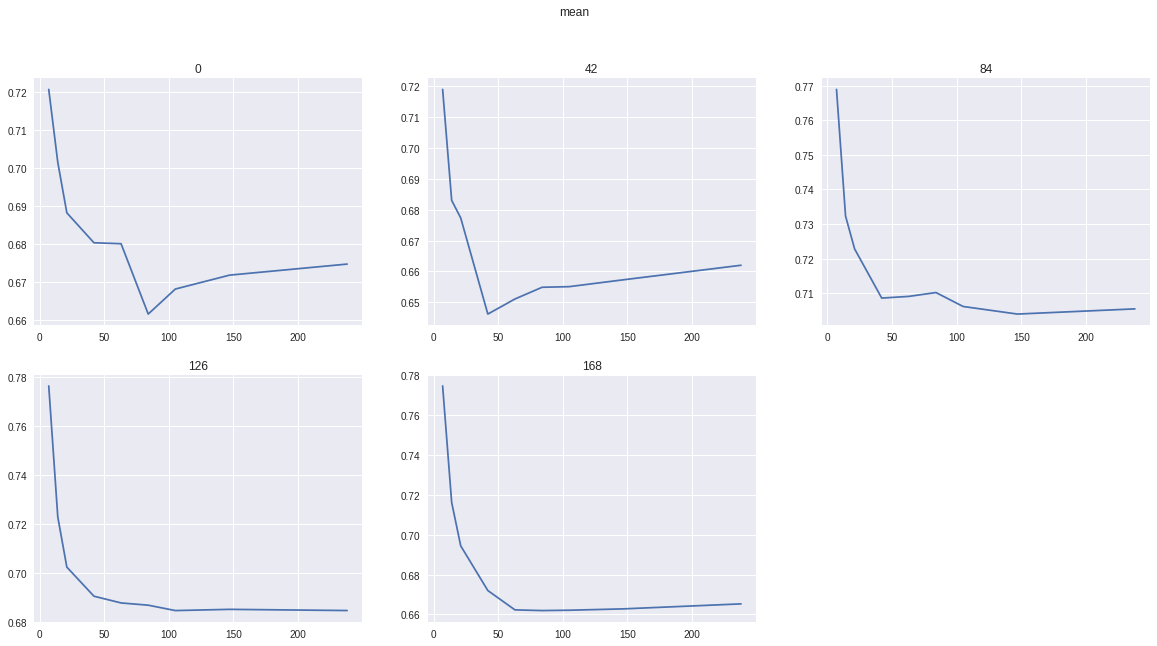

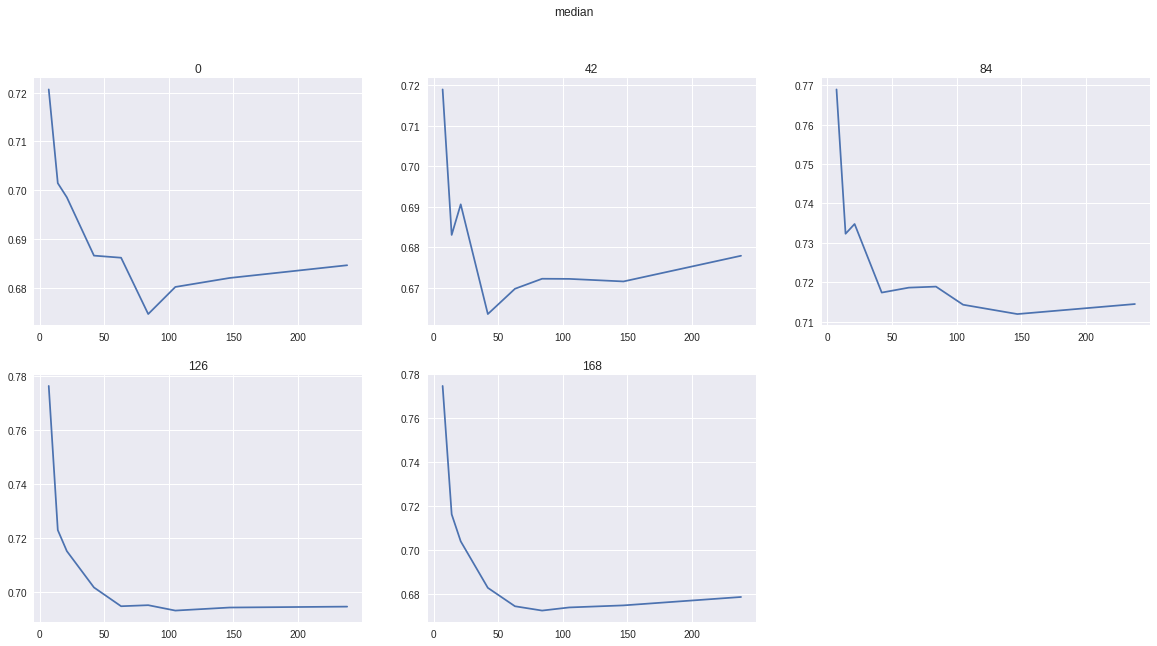

In [57]:
#Take Median at weekday level to make predicion
TEST_PERIOD=42 #Period is 39 days but take 42 days to make sure that that weekly patterns are captured

def get_prediction_error(x,window,timedelta,roll):
    test=x[-TEST_PERIOD-timedelta:len(x)-timedelta]
    train=x[-TEST_PERIOD-1-window-timedelta:-TEST_PERIOD-1-timedelta]
    if len(train)==0:
        return pd.Series({'sq_error':0,'len':0})
    train=train.values.reshape(int(window/7),7)
    if func=='mean':
        prediction=np.tile(np.nanmean(train,axis=0),6)
    else:
        prediction=np.tile(np.nanmedian(train,axis=0),6)
    sq_error=np.square((test-prediction).dropna()).sum()
    return pd.Series({'sq_error':sq_error,'len':len(test.dropna())})
 
    
time_delta=[0,42,84,126,168]
windows=[7,14,21,42,63,84,105,147,238] 
space=[x for x in product(windows,time_delta)]

for func in ['mean','median']:
    errors=[daily_visits.apply(get_prediction_error,axis=1,window=x,timedelta=y,roll=func).sum() for x,y in space]
    errors=pd.DataFrame(errors,index=pd.MultiIndex.from_tuples(space))
    errors['rmsle']=np.sqrt(errors['sq_error']/errors['len'])
    plt.figure(figsize=(20,10))
    plt.suptitle(func)
    for i,(name,group) in enumerate(errors.groupby(errors.index.get_level_values(1))):
        plt.subplot(2,3,i+1)
        plt.plot(group.index.get_level_values(0),group['rmsle'])
        plt.title(name)


/home/arpit.goel2/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


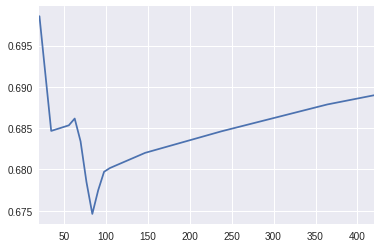

In [53]:
#Take Median at weekday level to make predicion
TEST_PERIOD=42 #Period is 39 days but take 42 days to make sure that that weekly patterns are captured

def get_prediction_error(x,window):
    test=x[-TEST_PERIOD:]
    train=x[-TEST_PERIOD-1-window:-TEST_PERIOD-1]
    if len(train)==0:
        return pd.Series({'sq_error':0,'len':0})
    train=train.values.reshape(int(window/7),7)
    prediction=np.tile(np.nanmedian(train,axis=0),6)
    sq_error=np.square((test-prediction).dropna()).sum()
    return pd.Series({'sq_error':sq_error,'len':len(test.dropna())})
    
windows=[21,35,56,63,70,77,84,91,98,105,147,238,364,420] 
errors=[daily_visits.apply(get_prediction_error,axis=1,window=window).sum() for window in windows]
errors=pd.DataFrame(errors,index=windows)
errors['rmsle']=np.sqrt(errors['sq_error']/errors['len'])
errors['rmsle'].plot()

In [7]:
TEST_PERIOD=39 #Period is 39 days but take 42 days to make sure that that weekly patterns are captured
TRAINING_WINDOW_WEEK=84 #Take 84 days as training window and get median weekday visits as benchmark
TRAINING_WINDOW_OVERALL=70 

def get_median_weekday_visit(x):
    train=x[-TRAINING_WINDOW_WEEK:]
    train=train.values.reshape(12,7)
    prediction=pd.Series(np.tile(np.nanmedian(train,axis=0),6))
    prediction=prediction.fillna(np.nanmedian(x[-63:]))
    return np.round(np.exp(prediction)-1)

def get_mean_weekday_visit(x):
    train=x[-TRAINING_WINDOW_WEEK:]
    train=train.values.reshape(12,7)
    prediction=pd.Series(np.tile(np.nanmean(train,axis=0),6))
    prediction=prediction.fillna(np.nanmean(x[-42:]))
    return np.round(np.exp(prediction)-1)

predictions=daily_visits.apply(get_median_weekday_visit,axis=1).unstack().reset_index()
predictions.columns=['delta','air_store_id','visitors']
predictions.index=predictions['air_store_id']+'_'+predictions['delta'].map(lambda x: (datetime(2017,4,23)+timedelta(days=x)).strftime('%Y-%m-%d'))
predictions=predictions['visitors']
df_sample_submission=pd.read_csv('01.RawData/sample_submission.csv')
df_sample_submission['visitors']=df_sample_submission['id'].map(predictions)
df_sample_submission.to_csv('03.Submissions/2.MedianSubmissionWeekday.csv',index=False)

/home/arpit.goel2/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [65]:
TEST_PERIOD=42 #Period is 39 days but take 42 days to make sure that that weekly patterns are captured
TRAINING_WINDOW_WEEK=84 #Take 84 days as training window and get median weekday visits as benchmark
TRAINING_WINDOW_OVERALL_MEDIAN=63 
TRAINING_WINDOW_OVERALL_MEAN=42 
predictions_1=daily_visits.apply(lambda x: x[-TRAINING_WINDOW_OVERALL_MEDIAN-TEST_PERIOD:-TEST_PERIOD].dropna().median(),axis=1)
predictions_2=daily_visits.apply(lambda x: x[-TRAINING_WINDOW_OVERALL_MEAN-TEST_PERIOD:-TEST_PERIOD].dropna().mean(),axis=1)
predictions_3=daily_visits.apply(lambda x: get_median_weekday_visit(x[-TRAINING_WINDOW_WEEK-TEST_PERIOD:-TEST_PERIOD]),axis=1).unstack().reset_index()
predictions_4=daily_visits.apply(lambda x: get_mean_weekday_visit(x[-TRAINING_WINDOW_WEEK-TEST_PERIOD:-TEST_PERIOD]),axis=1).unstack().reset_index()
predictions_3.columns=['delta','air_store_id','prediction_3']
predictions_4.columns=['delta','air_store_id','prediction_4']
predictions_3.loc[:,'visit_date']=predictions_3.loc[:,'delta'].map(lambda x: (datetime(2017,4,23)+timedelta(days=x-TEST_PERIOD)))
predictions_4.loc[:,'visit_date']=predictions_4.loc[:,'delta'].map(lambda x: (datetime(2017,4,23)+timedelta(days=x-TEST_PERIOD)))

combination_predicion=df_air_visit_data[df_air_visit_data.loc[:,'visit_date']>=datetime(2017,4,23)+timedelta(days=-TEST_PERIOD)]
combination_predicion.loc[:,'prediction_1']=combination_predicion.loc[:,'air_store_id'].map(predictions_1).fillna(2.8)
combination_predicion.loc[:,'prediction_2']=combination_predicion.loc[:,'air_store_id'].map(predictions_2).fillna(2.8)
combination_predicion=pd.merge(combination_predicion,predictions_3,on=['air_store_id','visit_date'])
combination_predicion=pd.merge(combination_predicion,predictions_4,on=['air_store_id','visit_date'])
combination_predicion.loc[:,'prediction_3']=np.log(1+combination_predicion.loc[:,'prediction_3']).fillna(2.8)
combination_predicion.loc[:,'prediction_4']=np.log(1+combination_predicion.loc[:,'prediction_4']).fillna(2.8)

from sklearn.linear_model import LinearRegression

reg=LinearRegression()
reg.fit(combination_predicion.loc[:,['prediction_2','prediction_3','prediction_4']],combination_predicion.loc[:,'log_visitors'])
print (reg.intercept_,reg.coef_)

/home/arpit.goel2/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: Mean of empty slice
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: Mean of empty slice
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

0.00464512885738 [ 0.19307521  0.18425902  0.63119156]


In [67]:
TEST_PERIOD=39 #Period is 39 days but take 42 days to make sure that that weekly patterns are captured
TRAINING_WINDOW_WEEK=84 #Take 84 days as training window and get median weekday visits as benchmark
TRAINING_WINDOW_OVERALL=63 

def get_prediction(x):
    train=x[-TRAINING_WINDOW_WEEK:]
    train=train.values.reshape(12,7)
    prediction_1=np.nanmedian(x[-63:])
    prediction_2=np.nanmean(x[-42:])
    prediction_3=pd.Series(np.tile(np.nanmedian(train,axis=0),6)).fillna(prediction_1)
    prediction_4=pd.Series(np.tile(np.nanmean(train,axis=0),6)).fillna(prediction_2)
    prediction=0.00464512885738+0.19307521*prediction_2+0.18425902*prediction_3+0.63119156*prediction_4
    return np.round(np.exp(prediction)-1)

predictions=daily_visits.apply(get_prediction,axis=1).unstack().reset_index()
predictions.columns=['delta','air_store_id','visitors']
predictions.index=predictions['air_store_id']+'_'+predictions['delta'].map(lambda x: (datetime(2017,4,23)+timedelta(days=x)).strftime('%Y-%m-%d'))
predictions=predictions['visitors']
df_sample_submission=pd.read_csv('01.RawData/sample_submission.csv')
df_sample_submission['visitors']=df_sample_submission['id'].map(predictions)
df_sample_submission.to_csv('03.Submissions/8.MeanMedianSubmission.csv',index=False)

/home/arpit.goel2/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: Mean of empty slice
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Mean of empty slice


In [69]:
#For restaraunts with last year data, use last year visits as an input feature
def get_last_year_features(x):
    features=x[-364:-364+42]
    features.index=features.index+timedelta(days=364)
    if len(features[np.isnan(features)])>20 or len(features[np.isnan(features)])==0:
        return features
    nans=np.isnan(features)
    f=features.nonzero()[0]
    features[nans]=np.interp(nans.nonzero()[0], (~nans).nonzero()[0], features[~nans])
    return features
    
daily_visits.loc[['air_81a12d67c22e012f'],:].apply(lambda x: get_last_year_features(x[:-42]),axis=1)


visit_date,2017-03-12 00:00:00,2017-03-13 00:00:00,2017-03-14 00:00:00,2017-03-15 00:00:00,2017-03-16 00:00:00,2017-03-17 00:00:00,2017-03-18 00:00:00,2017-03-19 00:00:00,2017-03-20 00:00:00,2017-03-21 00:00:00,...,2017-04-13 00:00:00,2017-04-14 00:00:00,2017-04-15 00:00:00,2017-04-16 00:00:00,2017-04-17 00:00:00,2017-04-18 00:00:00,2017-04-19 00:00:00,2017-04-20 00:00:00,2017-04-21 00:00:00,2017-04-22 00:00:00
air_store_id,,,,,,,,,,,,,,,,,,,,,
air_81a12d67c22e012f,2.772589,2.772589,3.091042,2.995732,2.079442,3.465736,2.772589,1.098612,1.700599,2.302585,...,2.833213,3.295837,2.890372,3.012933,3.135494,2.995732,2.639057,3.258097,3.178054,2.397895


In [72]:
TEST_PERIOD=42 #Period is 39 days but take 42 days to make sure that that weekly patterns are captured
TRAINING_WINDOW_WEEK=84 #Take 84 days as training window and get median weekday visits as benchmark
TRAINING_WINDOW_OVERALL=70 

predictions_1=daily_visits.apply(lambda x: x[-TRAINING_WINDOW_OVERALL_MEDIAN-TEST_PERIOD:-TEST_PERIOD].dropna().median(),axis=1)
predictions_2=daily_visits.apply(lambda x: x[-TRAINING_WINDOW_OVERALL_MEAN-TEST_PERIOD:-TEST_PERIOD].dropna().mean(),axis=1)
predictions_3=daily_visits.apply(lambda x: get_median_weekday_visit(x[-TRAINING_WINDOW_WEEK-TEST_PERIOD:-TEST_PERIOD]),axis=1).unstack().reset_index()
predictions_4=daily_visits.apply(lambda x: get_mean_weekday_visit(x[-TRAINING_WINDOW_WEEK-TEST_PERIOD:-TEST_PERIOD]),axis=1).unstack().reset_index()
predictions_3.columns=['delta','air_store_id','prediction_3']
predictions_4.columns=['delta','air_store_id','prediction_4']
predictions_3.loc[:,'visit_date']=predictions_3.loc[:,'delta'].map(lambda x: (datetime(2017,4,23)+timedelta(days=x-TEST_PERIOD)))
predictions_4.loc[:,'visit_date']=predictions_4.loc[:,'delta'].map(lambda x: (datetime(2017,4,23)+timedelta(days=x-TEST_PERIOD)))
predictions_5=daily_visits.apply(lambda x: get_last_year_features(x[:-TEST_PERIOD]),axis=1).unstack().reset_index()
predictions_5.columns=['visit_date','air_store_id','prediction_5']

combination_predicion=df_air_visit_data[df_air_visit_data.loc[:,'visit_date']>=datetime(2017,4,23)+timedelta(days=-TEST_PERIOD)]
combination_predicion.loc[:,'prediction_1']=combination_predicion.loc[:,'air_store_id'].map(predictions_1).fillna(2.8)
combination_predicion.loc[:,'prediction_2']=combination_predicion.loc[:,'air_store_id'].map(predictions_2).fillna(2.8)
combination_predicion=pd.merge(combination_predicion,predictions_3,on=['air_store_id','visit_date'])
combination_predicion=pd.merge(combination_predicion,predictions_4,on=['air_store_id','visit_date'])
combination_predicion.loc[:,'prediction_3']=np.log(1+combination_predicion.loc[:,'prediction_3']).fillna(2.8)
combination_predicion.loc[:,'prediction_4']=np.log(1+combination_predicion.loc[:,'prediction_4']).fillna(2.8)
combination_predicion=pd.merge(combination_predicion,predictions_5,on=['air_store_id','visit_date'],how='left')


prediction_wlyear=combination_predicion[combination_predicion['prediction_5'].notnull()]
prediction_wolyear=combination_predicion[combination_predicion['prediction_5'].isnull()]

from sklearn.linear_model import LinearRegression

reg=LinearRegression()
reg.fit(prediction_wlyear.loc[:,['prediction_2','prediction_3','prediction_4','prediction_5']],prediction_wlyear.loc[:,'log_visitors'])
print (reg.intercept_,reg.coef_)

reg=LinearRegression()
reg.fit(combination_predicion.loc[:,['prediction_2','prediction_3','prediction_4']],combination_predicion.loc[:,'log_visitors'])
print (reg.intercept_,reg.coef_)

/home/arpit.goel2/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: Mean of empty slice
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: Mean of empty slice
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

-0.0959623876764 [ 0.17071784  0.11487302  0.66129226  0.09267511]
0.00464512885738 [ 0.19307521  0.18425902  0.63119156]


In [18]:
TEST_PERIOD=39 #Period is 39 days but take 42 days to make sure that that weekly patterns are captured
TRAINING_WINDOW_WEEK=84 #Take 84 days as training window and get median weekday visits as benchmark
TRAINING_WINDOW_OVERALL=70 

def get_prediction(x,ret):
    train=x[-TRAINING_WINDOW_WEEK:]
    train=train.values.reshape(12,7)
    prediction_1=np.nanmedian(x[-63:])
    prediction_2=np.nanmean(x[-42:])
    prediction_3=pd.Series(np.tile(np.nanmedian(train,axis=0),6)).fillna(prediction_1)
    prediction_4=pd.Series(np.tile(np.nanmean(train,axis=0),6)).fillna(prediction_2)
    prediction_5=x[-364:-364+42]
    prediction_5.index=prediction_5.index+timedelta(days=364)
    prediction=0.00464512885738+prediction_2*0.19307521+prediction_3*0.18425902+prediction_4*0.63119156
    return [prediction_1,prediction_2,prediction_3,prediction_4,prediction][ret]
    
    if len(prediction_5[np.isnan(prediction_5)])>20:
        prediction=0.00464512885738+prediction_2*0.19307521+prediction_3*0.18425902+prediction_4*0.63119156
    else:
        nans=np.isnan(prediction_5)
        f=prediction_5.nonzero()[0]
        prediction_5[nans]=np.interp(nans.nonzero()[0], (~nans).nonzero()[0], prediction_5[~nans])
        prediction_5.index=range(42)
        prediction=-0.0959623876764+prediction_2*0.17071784+prediction_3*0.11487302+prediction_4*0.66129226+prediction_5*0.09267511
    return np.round(np.exp(prediction)-1)

#daily_visits.loc[['air_81a12d67c22e012f'],:].apply(get_prediction,axis=1)
# predictions=daily_visits.apply(get_prediction,axis=1).unstack().reset_index()
# predictions.columns=['delta','air_store_id','visitors']
# predictions.index=predictions['air_store_id']+'_'+predictions['delta'].map(lambda x: (datetime(2017,4,23)+timedelta(days=x)).strftime('%Y-%m-%d'))
# predictions=predictions['visitors']
# df_sample_submission=pd.read_csv('01.RawData/sample_submission.csv')
# df_sample_submission['visitors']=df_sample_submission['id'].map(predictions)
# df_sample_submission.to_csv('03.Submissions/9.LastYear_MeanMedianSubmissionCombined.csv',index=False)

In [23]:
daily_visits.head(1).apply(get_prediction,axis=1,ret=4)

/home/arpit.goel2/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: Mean of empty slice


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
air_store_id,,,,,,,,,,,,,,,,,,,,,
air_00a91d42b08b08d9,3.342494,3.289072,3.43652,3.395497,3.516769,3.554218,2.649821,3.342494,3.289072,3.43652,...,3.516769,3.554218,2.649821,3.342494,3.289072,3.43652,3.395497,3.516769,3.554218,2.649821


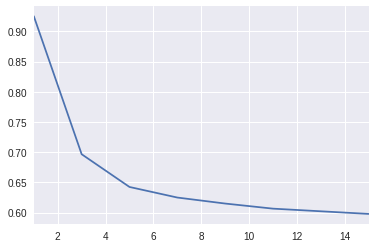

In [186]:
#Get nearest neighbours based on visits in last 84 days
def get_normalised_visits(x,delta):
    trips=x[-42-delta:-delta]
    if len(trips.dropna())<20:
        return trips
    nans=np.isnan(trips)
    f=trips.nonzero()[0]
    try:
        trips[nans]=np.interp(nans.nonzero()[0], (~nans).nonzero()[0], trips[~nans])
        return trips
    except:
        return trips

def extrapolate_trips(x,neighbours):
    x=x.sort_values(ascending=False)[:neighbours]
    x=x[x>0]
    trips_vector=[]
    for key,value in x.to_dict().items():
        key_vector=cleaned_daily_visits.loc[key,:]
        key_vector_ly=cleaned_daily_visits_ly.loc[key,:]
        key_vector=(key_vector_ly-key_vector.mean())/key_vector.std()
        trips_vector.append(key_vector.values)
    present_trip_vector=cleaned_daily_visits.loc[x.name,:]
    trips_vector=pd.DataFrame(trips_vector,columns=[x+timedelta(days=364) for x in cleaned_daily_visits_ly.columns])
    trips_vector=trips_vector*present_trip_vector.std()+present_trip_vector.mean()
    return (pd.DataFrame(trips_vector,columns=[x+timedelta(days=364) for x in cleaned_daily_visits_ly.columns]).mean())

cleaned_daily_visits=daily_visits.apply(get_normalised_visits,axis=1,delta=42).dropna()
cleaned_daily_visits_ly=daily_visits.apply(get_normalised_visits,axis=1,delta=364).dropna()
correlations=cleaned_daily_visits.T.corr().fillna(0)
correlations=correlations.loc[correlations.index.difference(cleaned_daily_visits_ly.index).tolist(),:]
correlations=correlations.loc[:,correlations.columns.intersection(cleaned_daily_visits_ly.index).tolist()]

errors={}
for neighbour in [1,3,5,7,9,11,15]:
    extrapolated_trips=correlations.apply(extrapolate_trips,axis=1,neighbours=neighbour).fillna(0)
    err=np.square(daily_visits.loc[extrapolated_trips.index,extrapolated_trips.columns]-extrapolated_trips)
    errors[neighbour]=np.sqrt(err.mean().mean())
pd.Series(errors).plot()

In [9]:
#Final Model. Add previous year pattern using correlated stores' trips. Take top 11 stores

TEST_PERIOD=42 #Period is 39 days but take 42 days to make sure that that weekly patterns are captured
TRAINING_WINDOW_WEEK=84 #Take 84 days as training window and get median weekday visits as benchmark
TRAINING_WINDOW_OVERALL=70 
predictions_1=daily_visits.apply(lambda x: x[-TRAINING_WINDOW_OVERALL-TEST_PERIOD:-TEST_PERIOD].dropna().median(),axis=1)
predictions_2=daily_visits.apply(lambda x: get_median_weekday_visit(x[-TRAINING_WINDOW_WEEK-TEST_PERIOD:-TEST_PERIOD]),axis=1).unstack().reset_index()
predictions_2.columns=['delta','air_store_id','prediction_2']
predictions_2.loc[:,'visit_date']=predictions_2.loc[:,'delta'].map(lambda x: (datetime(2017,4,23)+timedelta(days=x-TEST_PERIOD)))
# predictions_3=daily_visits.apply(lambda x: get_last_year_features(x[:-TEST_PERIOD]),axis=1).unstack().reset_index()
# predictions_3.columns=['visit_date','air_store_id','prediction_3']
# predictions_4=correlations.apply(extrapolate_trips,axis=1,neighbours=11).fillna(0).unstack().reset_index()
# predictions_4.columns=['visit_date','air_store_id','prediction_4']

combination_predicion=df_air_visit_data[df_air_visit_data.loc[:,'visit_date']>=datetime(2017,4,23)+timedelta(days=-TEST_PERIOD)]
combination_predicion.loc[:,'prediction_1']=combination_predicion.loc[:,'air_store_id'].map(predictions_1).fillna(2.8)
combination_predicion=pd.merge(combination_predicion,predictions_2,on=['air_store_id','visit_date'])
combination_predicion.loc[:,'prediction_2']=np.log(1+combination_predicion.loc[:,'prediction_2']).fillna(2.8)
# combination_predicion=pd.merge(combination_predicion,predictions_3,on=['air_store_id','visit_date'],how='left')
# combination_predicion=pd.merge(combination_predicion,predictions_4,on=['air_store_id','visit_date'],how='left')

# prediction_wlyear=combination_predicion[combination_predicion['prediction_3'].notnull()]
# prediction_wlyear_extrpl=combination_predicion[combination_predicion['prediction_4'].notnull()]
# prediction_woyear=combination_predicion[((combination_predicion['prediction_4'].isnull()) &(combination_predicion['prediction_3'].isnull()))  ]

from sklearn.linear_model import LinearRegression

# reg=LinearRegression()
# reg.fit(prediction_wlyear.loc[:,['prediction_1','prediction_2','prediction_3']],prediction_wlyear.loc[:,'log_visitors'])
# print (reg.score(prediction_wlyear.loc[:,['prediction_1','prediction_2','prediction_3']],prediction_wlyear.loc[:,'log_visitors']))
# print (reg.intercept_,reg.coef_)

# reg=LinearRegression()
# reg.fit(prediction_wlyear_extrpl.loc[:,['prediction_1','prediction_2','prediction_4']],prediction_wlyear_extrpl.loc[:,'log_visitors'])
# print (reg.score(prediction_wlyear_extrpl.loc[:,['prediction_1','prediction_2','prediction_4']],prediction_wlyear_extrpl.loc[:,'log_visitors']))
# print (reg.intercept_,reg.coef_)

reg=LinearRegression()
reg.fit(combination_predicion.loc[:,['prediction_1','prediction_2']],combination_predicion.loc[:,'log_visitors'])
print (reg.score(combination_predicion.loc[:,['prediction_1','prediction_2']],combination_predicion.loc[:,'log_visitors']))
print (reg.intercept_,reg.coef_)

/home/arpit.goel2/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.570123997055
0.047926763455 [ 0.22113019  0.76218101]


In [5]:
TEST_PERIOD=39 #Period is 39 days but take 42 days to make sure that that weekly patterns are captured
TRAINING_WINDOW_WEEK=84 #Take 84 days as training window and get median weekday visits as benchmark
TRAINING_WINDOW_OVERALL=70 

cleaned_daily_visits=daily_visits.apply(get_normalised_visits,axis=1,delta=0).dropna()
cleaned_daily_visits_ly=daily_visits.apply(get_normalised_visits,axis=1,delta=364+42).dropna()
correlations=cleaned_daily_visits.T.corr().fillna(0)
#correlations=correlations.loc[correlations.index.difference(cleaned_daily_visits_ly.index).tolist(),:]
correlations=correlations.loc[:,correlations.columns.intersection(cleaned_daily_visits_ly.index).tolist()]
extrapolated_trips=correlations.apply(extrapolate_trips,axis=1,neighbours=11).fillna(0)


def get_prediction(x):
    train=x[-TRAINING_WINDOW_WEEK:]
    train=train.values.reshape(12,7)
    prediction=pd.Series(np.tile(np.nanmedian(train,axis=0),6))
    prediction=prediction.fillna(np.nanmedian(x[-TRAINING_WINDOW_OVERALL:]))
    overall_median=x[-TRAINING_WINDOW_OVERALL:].dropna().median()
    
    last_year_values=x[-364:-364+42]
    last_year_values.index=last_year_values.index+timedelta(days=364)
    
    if len(last_year_values[np.isnan(last_year_values)])>20:
        prediction=0.0480473659449+0.76235707*prediction+0.22090911*overall_median
    elif x.name not in extrapolated_trips.index:
        nans=np.isnan(last_year_values)
        f=last_year_values.nonzero()[0]
        last_year_values[nans]=np.interp(nans.nonzero()[0], (~nans).nonzero()[0], last_year_values[~nans])
        last_year_values.index=range(42)
        prediction=-0.0742650393378+0.71349765*prediction+0.19723068*overall_median+0.1102198*last_year_values
    else:
        prediction=0.0442263643183+0.59438342*prediction+0.02856352*overall_median+0.35134492*extrapolated_trips.loc[x.name,:].values
    return np.round(np.exp(prediction)-1)

#daily_visits.loc[['air_81a12d67c22e012f'],:].apply(get_prediction,axis=1)
predictions=daily_visits.apply(get_prediction,axis=1).unstack().reset_index()
predictions.columns=['delta','air_store_id','visitors']
predictions.index=predictions['air_store_id']+'_'+predictions['delta'].map(lambda x: (datetime(2017,4,23)+timedelta(days=x)).strftime('%Y-%m-%d'))
predictions=predictions['visitors']
df_sample_submission=pd.read_csv('01.RawData/sample_submission.csv')
df_sample_submission['visitors']=df_sample_submission['id'].map(predictions)
df_sample_submission.to_csv('03.Submissions/6.LastYearAllCorrelated11Stores_MedianSubmissionCombined.csv',index=False)

/home/arpit.goel2/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


NameError: ("name 'extrapolated_trips' is not defined", 'occurred at index air_00a91d42b08b08d9')

In [103]:
from itertools import product
TEST_PERIOD=42 #Period is 39 days but take 42 days to make sure that that weekly patterns are captured

def predict_scale(x,window,timedelta):
    test=x[-TEST_PERIOD-timedelta:len(x)-timedelta].dropna().sort_values()
    train=x[-TEST_PERIOD-1-window-timedelta:-TEST_PERIOD-1-timedelta].dropna().sort_values()
    if len(train)<=2 or len(test)<=2:
        return pd.Series({'train':np.nan,'test':np.nan,'window':window,'timedelta':timedelta})
    else:
        train_scale=train[-1]-train[1]
        test_scale=test[-1]-test[1]
        return pd.Series({'train':train_scale,'test':test_scale,'window':window,'timedelta':timedelta})
    
def predict_trend(x,window,timedelta):
    test=x[-TEST_PERIOD-1-window-timedelta:len(x)-timedelta]
    train=x[-TEST_PERIOD-1-window-timedelta:-TEST_PERIOD-1-timedelta]
    train_index=np.arange(len(train))[train.notnull()]
    test_index=np.arange(len(test))[test.notnull()]
    
    if train.dropna().shape[0]<=2 or test.dropna().shape[0]<=2:
        return pd.Series({'train':np.nan,'test':np.nan,'window':window,'timedelta':timedelta})
    else:
        train_coef= np.polyfit(train_index,train[train.notnull()],1,full=True)[0][0]
        test_coef= np.polyfit(test_index,test[test.notnull()],1,full=True)[0][0]
        return pd.Series({'train':train_coef,'test':test_coef,'window':window,'timedelta':timedelta})
    

#time_delta=[0,42,84,126,168,210]
time_delta=[0]
windows=[7,14,21,42,49,56,63,105,147,238] 
#time_delta=[0]
#windows=[42]
space=[x for x in product(windows,time_delta)]


#scales=[daily_visits.apply(predict_scale,axis=1,window=x,timedelta=y) for x,y in space]
#scales=pd.concat(scales).dropna()
#scales['ratio']=scales['test']/scales['train']
#scales['ratio_bin']=pd.cut(scales['ratio'],bins=[0,0.25,0.5,1,2,4,1000],labels=['1.[0,0.25]','2.[0.25,0.5]','3.[0.5,1]','4.[1,2]','5.[2,4]','6[4,]'])
#scales.groupby(['window','ratio_bin'])['ratio'].count().unstack()

trends=[daily_visits.apply(predict_trend,axis=1,window=x,timedelta=y) for x,y in space]
trends=pd.concat(trends).dropna()
trends['ratio']=trends['test']/trends['train']
trends['ratio_bin']=pd.cut(trends['ratio'],bins=[0,0.25,0.5,1,2,4,1000],labels=['1.[0,0.25]','2.[0.25,0.5]','3.[0.5,1]','4.[1,2]','5.[2,4]','6[4,]'])
trends.groupby(['window','ratio_bin'])['ratio'].count().unstack()


ratio_bin,"1.[0,0.25]","2.[0.25,0.5]","3.[0.5,1]","4.[1,2]","5.[2,4]","6[4,]"
window,,,,,,
7.0,401,38,12,9,1,3
14.0,329,56,43,22,10,8
21.0,269,106,69,25,18,19
42.0,134,117,121,58,30,43
49.0,130,123,119,75,48,25
56.0,121,117,137,78,35,41
63.0,107,117,165,81,42,39
105.0,113,134,191,118,43,28
147.0,82,99,227,141,55,30


In [ ]:
errors['rmsle']=np.sqrt(errors['sq_error']/errors['len'])
    plt.figure(figsize=(20,10))
    plt.suptitle(func)
    for i,(name,group) in enumerate(errors.groupby(errors.index.get_level_values(1))):
        plt.subplot(2,3,i+1)
        plt.plot(group.index.get_level_values(0),group['rmsle'])
        plt.title(name)

In [104]:
df_store_master

NameError: name 'df_store_master' is not defined